In [43]:
!pip install datasets transformers[sentencepiece] peft evaluate rouge_score -q

# NLP, DS-поток
## Задание 4
### Parameter-Efficient Fine-Tuning.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**
  * Работа с данными &mdash; 10 баллов;
  * Обучение моделей &mdash; 80 баллов;
  * Оценка качества &mdash; 40 баллов;
  * Сравнение моделей &mdash; 20 баллов.


In [44]:
# Bot check

# HW_ID: ds_nlp4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [62]:
import transformers
import evaluate
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, palette="Set2")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, DataCollatorForSeq2Seq, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, T5ForConditionalGeneration, T5Tokenizer
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, TaskType, LoraConfig
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Описание задачи

В этом домашнем задании мы будем работать c моделью [ruT5](https://habr.com/ru/company/sberbank/blog/567776/) на данных новостей с портала [Газета.Ru](https://www.kaggle.com/datasets/phoenix120/gazeta-summaries) над задачей суммаризации новостей. Обычно при обсуждении задачи суммаризации выделяют два основных подхода:
* **Экстрактивная суммаризация.** В этом случае из исходного текста выделяются наиболее важные фрагменты, ключевые слова, которые и будут являться сжатым содержанием.
* **Абстрактивная суммаризация.** Этот подход отличается тем, что краткое содержание исходного текста порождается некоторой генеративной моделью.

В этом домашнем задании мы решаем задачу абстрактивной суммаризации. При решении задачи мы не будем обучать модель целиком, а попробуем применить некоторые подходы эффективного по параметрам обучения с помощью библиотеки [PEFT](https://github.com/huggingface/peft).

Надо оговориться, что идея применения T5-based архитектур для решения задач суммаризации на русском языке [не нова](https://sbercloud.ru/ru/datahub/rugpt3family/summarizer). Основной смысл задания состоит в том, чтобы реализовать полный пайплайна частичного обучения модели с помощью библиотеки `peft` и оценить получившееся качество. При выполнении задания **не разрешается** использовать предобученные на этой задаче модели, например [такую](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta). Мы будем использовать модели, обученные только на задачу денойзинга, то есть `ruT5-base` или, при наличии ресурсов, `ruT5-large`.

Рассмотрим пример генерации с помощью `ruT5-base` для задачи денойзинга или заполнения слотов. Для инференса `transformers` предоставляет удобный метод `.generate(...)`. В зависимоcти от переданных параметров можно генерировать  с использованием жадной стратегии, сэмплирования с температурой, top-k или top-p сэмплирования, а также использовать beam search. Рекомендуется ознакомиться с [постом](https://huggingface.co/blog/how-to-generate), в котором показаны примеры применения различных стратегий декодирования. Если у вас есть некоторые сомнения, связанные с пониманием работы полноценного трансформера с encoder-decoder архитектурой, то рекомендуется ознакомиться также с [этим](https://huggingface.co/blog/encoder-decoder#encoder-decoder) постом.

In [46]:
model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-base")

In [47]:
input_ids = tokenizer(
    "Снижение цен <extra_id_0> в Москве возможно только при <extra_id_1> " +
    "Это условие названо в аналитической заметке портала Новости <extra_id_2> ",
    return_tensors='pt'
)["input_ids"]
out_ids = model.generate(
    input_ids=input_ids,                 # послд-ть входных токенов, в нашем случае вход декодера
    max_length=64,                       # макс. длина ген. послед-ти
    eos_token_id=tokenizer.eos_token_id, # eos токен
    num_beams=5,                         # указываем num_beams - будет использован beam_search
)
tokenizer.decode(out_ids[0])

'<pad> <extra_id_0> на жилье <extra_id_1> соблюдении ряда условий. <extra_id_2> Москвы</s>'

Обратите внимание, что роль bos-токена играет `<pad>`. Далее, пропуски`<extra_id_X>` раскрываются в возможные фрагменты текста. В данном случае `<extra_id_0>`, `<extra_id_1>` и т.п. &mdash; это спец токены, которые которые модель должна заполнить, тем самым решая задачу денойзинга. Т.к. T5 &mdash; полноценный трансформер, на вход энкодера во время предобучения приходит текст с этими спец. токенами, а на вход декодера – те последовательности, что должны быть на месте спец. токенов.

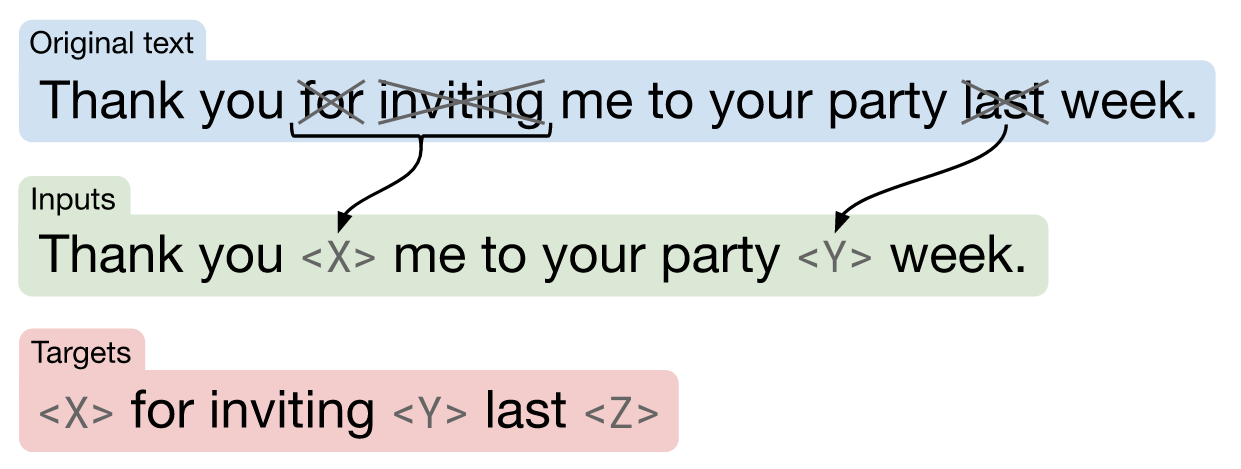

## Работа с данными

Теперь загрузим данные. Если при решении задания у вас возникнут проблемы из-за большого объема данных, например, не будет хватать оперативной памяти, то **можете взять подвыборку разумного** размера из обучающего и валидационного датасета.

In [48]:
dataset = load_dataset("IlyaGusev/gazeta", revision="v1.0", trust_remote_code=True)

In [49]:
train_data, val_data = dataset['train'], dataset['validation']

Посмотрим, из чего состоит обучающий пример. Нас будут интересовать поля `text`, `summary`.

In [50]:
{k:(v if len(v)<100 else f'{v[:100]}...') for k,v in train_data[13].items()}

{'text': 'Российскому певцу Андрею Губину исполнилось 45 лет. Последнее время артист залег на дно и перестал р...',
 'summary': 'Продюсер Андрей Разин рассказал о серьезных проблемах с психикой у музыканта Андрея Губина, которому...',
 'title': '«Проблемы с психикой»: раскрыта страшная тайна Андрея Губина',
 'date': '2019-04-30 16:55:17',
 'url': 'https://www.gazeta.ru/culture/2019/04/30/a_12331549.shtml'}

Выделим необходимые поля.

In [51]:
train_text, train_summary = [x['text'] for x in train_data], [x['summary'] for x in train_data]
val_text, val_summary = [x['text'] for x in val_data], [x['summary'] for x in val_data]

Соберем датасеты.

In [52]:
train_dataset = Dataset.from_dict({"text": train_text, "summary": train_summary})
val_dataset = Dataset.from_dict({"text": val_text, "summary": val_summary})

Напишем функцию для препроцессинга наших данных. Архитектурно модель `ruT5` &mdash; это полноценный трансформер. На вход модели будет поступать исходный текст новости, по которому она будет пытаться сгенерировать его сжатое саммари.

In [53]:
def preprocess_function(examples):
    """ Функция препроцессинга для обработки данных. """
    inputs, targets = examples["text"], examples["summary"]  # выделим input / targets для модели
    # токенизируем новости, это вход энкодера; наша source-последовательность
    model_inputs = tokenizer(inputs, max_length=500, padding="max_length", truncation=True, return_tensors="pt")
    # токенизируем саммари, это входе декодера во время обучения; наша target-последовательность
    labels = tokenizer(targets, max_length=500, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]  # не будем считать лосс для паддинга; по умолчанию nn.CrossEntropy не учитыает в лоссе объекты с меткой -100
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels[0]  # сформируем вход для нашей модели
    model_inputs["input_ids"] = model_inputs["input_ids"][0] 
    model_inputs["attention_mask"] = model_inputs["attention_mask"][0]
    return model_inputs

Применим препроцессинг к датасету. Обратите внимание, что паддинг мы сделали заранее. Понятно, что это не очень эффективно. При желании рекомендуется это исправить, то есть перенести паддинг на момент формирования батча в data collator. Заметим также, что саммари обычно гораздо меньше исходной новости, поэтому выставлять `max_length` следует аккуратно.

In [54]:
train_dataset = train_dataset.map(preprocess_function, num_proc=2, desc="Tokenizing train dataset...")
val_dataset = val_dataset.map(preprocess_function, num_proc=2, desc="Tokenizing val dataset...")

Tokenizing train dataset... (num_proc=2):   0%|          | 0/52400 [00:00<?, ? examples/s]

Tokenizing val dataset... (num_proc=2):   0%|          | 0/5265 [00:00<?, ? examples/s]

## Обучение моделей

В библиотеке [`PEFT`](https://github.com/huggingface/peft) представлены различные подходы к эффективному по параметрам обучению. Рассмотрим некоторые из них.

### LoRA

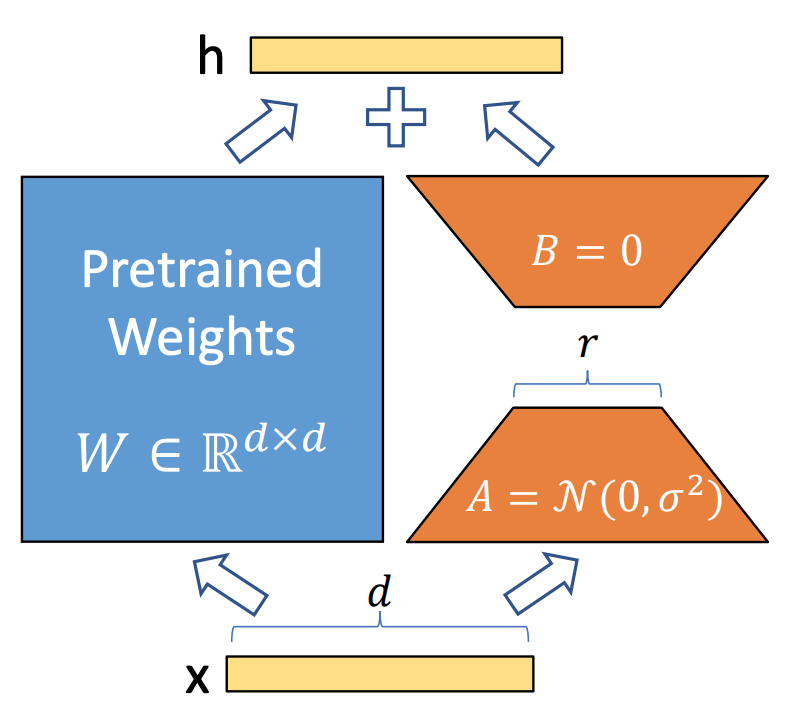

Позволяет повысить эффективность обучения посредством использования low-rank аппроксимации для матриц. Подробнее про метод и его использование можете прочитать [здесь](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

### IA^3
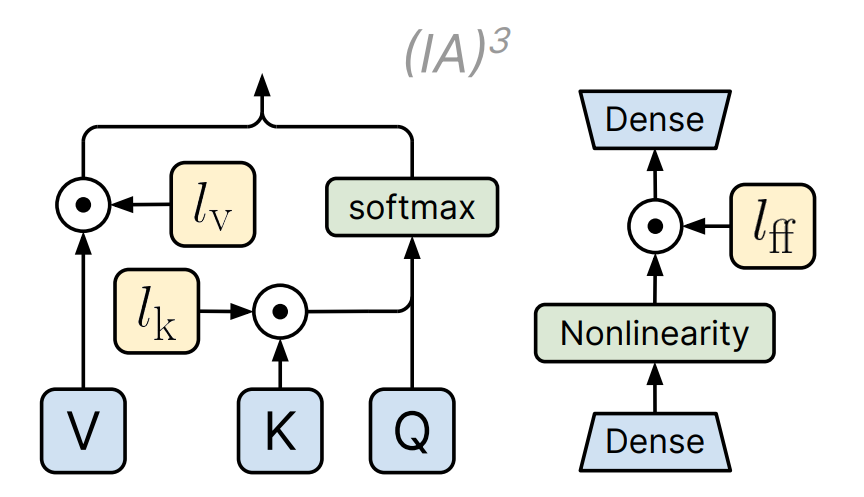

Метод IA3 (Infused Adapter by Inhibiting and Amplifying Inner Activations) добавляет в модель обучемые векторы $l_v$, $l_k$ и $l_{ff}$, которые умножаются (поэлементно) на соответствующие выходы слоев модели (см. изображение), таким образом добиваясь обучаемого рескейлинга. Обучение модели с таким адаптером получается даже эффективнее, чем обучение с использованием LoRA, и при этом результаты оказываются сопоставимыми с обычным fine-tuning.

Подробнее про подход можно прочитать [тут](https://huggingface.co/docs/peft/conceptual_guides/ia3).

Задать соотвествующий конфиг `peft`'a для нашей задачи можно так:
```
from peft import IA3Config, TaskType
peft_config = IA3Config(task_type=TaskType.SEQ_2_SEQ_LM, # задача seq2seq
                        inference_mode=False,
                        target_modules=...             # опционально можно задать  
                        feedforward_modules=...)       # target_modules / feedforward_modules
```

Обратите внимание, для LoRA также нужно будет указать верный `task_type`. На занятии мы рассматривали простую задачу классификации, а здесь же seq2seq.

Итак, вам предлагается обучить модели с использованием вышеописанных методов и сравнить их с обычным обычным fine-tuning'ом модели. Подумайте, какие преимущества и недостатки есть у каждого подхода.

Сравните модели при добавлении адаптер-слоев в различные модули. Попробуйте **2-3 варианта для каждого метода**. Для этого обратите внимание на аргументы `target_modules` и `feedforward_modules` во время конфигураций адаптеров. Мы используем модель на базе T5, по умолчанию в `peft` уже перечислены модули, в которые внедряются адаптеры для разных моделей. Например, для [LoRA](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L49) это `q` и `v` на каждом слое, а для [IA3](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L83)  &mdash; это `k`, `v` и `wo`.

Для LoRA попробуйте также различные 2-3 варианта гиперпараметра `r` через библиотеку `peft`. А также реализуйте свой кастомный слой-обертку в виде LoRA-адаптера над линейными слоями аттеншена в модулях `q` и `v`, обучите и сравните свою реализацию с реализацией через `peft`.

Начнем с собственной реализации LoRA-адаптера.


In [55]:
class LoRALayerWrapper(nn.Module):
    def __init__(self, original_layer, rank=8, alpha=16):
        super().__init__()
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)
        self.lora_A = nn.Parameter(torch.empty((original_layer.in_features, rank)))
        self.lora_B = nn.Parameter(torch.empty((rank, original_layer.out_features)))
        self.scaling = alpha/rank
        nn.init.zeros_(self.lora_A)
        nn.init.normal_(self.lora_B, mean=0.0, std=0.01)
    def forward(self, input):
        return self.original_layer(input) + self.scaling*(self.lora_A@self.lora_B@input.unsqueeze(-1)).squeeze(-1)

Проверим реализацию, сравнив ее с той, что предоставляет `peft`.

In [56]:
torch.manual_seed(42)
rank, alpha, dummy_input = 4, 32, torch.randn(1,1,768)
peft_config = LoraConfig(r=rank, lora_alpha=alpha, target_modules=["q","v"], lora_dropout=0.0, bias="none", task_type="SEQ_2_SEQ_LM")  # Реализация через peft
base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_model = get_peft_model(base_model, peft_config)

In [57]:
q_layer_to_test = peft_model.base_model.encoder.block[0].layer[0].SelfAttention.q  # возьмем один модуль для простого теста
base_linear_layer = q_layer_to_test.base_layer  # исходный линейный слой
our_model = LoRALayerWrapper(base_linear_layer, rank=rank, alpha=alpha)  # наша обертка
our_output, peft_output = our_model(dummy_input), q_layer_to_test(dummy_input)
assert torch.allclose(our_output, peft_output, atol=1e-4), "Что-то не так с простым forward"

Тест выше совсем простой, т.к. из-за особенности инициализации изначально LoRA ничего не делает. Добавим чуть более сложный тест-кейс.

In [58]:
dummy_B = torch.randn_like(our_model.lora_B.data)
with torch.no_grad():
    our_model.lora_B.data.copy_(dummy_B)  # скопируем параметры
    q_layer_to_test.lora_B.default.weight.data.copy_(dummy_B.T)
    our_model.lora_A.data.copy_(q_layer_to_test.lora_A.default.weight.data.T)
our_loss = our_model(dummy_input).sum()  # forward + backward pass для реализаций
our_loss.backward()
peft_loss = q_layer_to_test(dummy_input).sum()
peft_loss.backward()

In [ ]:
our_grad_A, peft_grad_A = our_model.lora_A.grad, q_layer_to_test.lora_A.default.weight.grad.T
our_grad_B, peft_grad_B = our_model.lora_B.grad, q_layer_to_test.lora_B.default.weight.grad.T
assert torch.allclose(our_grad_A, peft_grad_A, atol=1e-4), "Расхождения градиентов для матрицы A"
assert torch.allclose(our_grad_B, peft_grad_B, atol=1e-4), "Расхождения градиентов для матрицы B"

Теперь напишем функцию для оборачивания модулей `q`, `v` через реализованный слой.

In [69]:
def inject_lora(model, rank, alpha):
    for encoder_block in model.encoder.block:  # Энкодер
        self_attn = encoder_block.layer[0].SelfAttention
        self_attn.q, self_attn.v = LoRALayerWrapper(self_attn.q.original_layer, rank, alpha), LoRALayerWrapper(self_attn.v.original_layer, rank, alpha)
    for decoder_block in model.decoder.block:  # Декодер
        self_attn = decoder_block.layer[0].SelfAttention  # Self attention
        self_attn.q, self_attn.v = LoRALayerWrapper(self_attn.q.original_layer, rank, alpha), LoRALayerWrapper(self_attn.v.original_layer, rank, alpha)
        cross_attn = decoder_block.layer[1].EncDecAttention  # Cross attention
        cross_attn.q, cross_attn.v = LoRALayerWrapper(cross_attn.q.original_layer, rank, alpha), LoRALayerWrapper(cross_attn.v.original_layer, rank, alpha)
    for name, param in model.named_parameters():  # Замораживаем все параметры, размораживаем только LoRA-матрицы
        param.requires_grad_('lora' in name)
    return model

Отлично, теперь можно приступить к экспериментам. Не забудьте сравнить свою реализацию LoRA c аналогичной через `peft`.

In [70]:
training_args = TrainingArguments('.', evaluation_strategy="epoch", save_strategy="epoch", learning_rate=3e-4, \
 per_device_train_batch_size=12, per_device_eval_batch_size=12, num_train_epochs=1, weight_decay=0.01, load_best_model_at_end=True)
data_collator = DataCollatorForSeq2Seq(tokenizer)
models = []

for rank in [2,4,8]:
    for alpha in [16,32,64]:
        print(rank, alpha)
        inject_lora(base_model, rank, alpha)
        # base_model.print_trainable_parameters()
        trainer = Trainer(base_model, training_args, train_dataset=train_dataset, eval_dataset=val_dataset, data_collator=data_collator, tokenizer=tokenizer)
        trainer.train()
        models.append(deepcopy(base_model))

<ipython-input-70-8fb78da11562>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(base_model, training_args, train_dataset=train_dataset, eval_dataset=val_dataset, data_collator=data_collator, tokenizer=tokenizer)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## Оценка качества

Для оценки качества суммаризации можно использовать различные автоматические метрики:
* [BLEU](https://en.wikipedia.org/wiki/BLEU);
* [Rouge](https://en.wikipedia.org/wiki/ROUGE_(metric));
* [METEOR](https://en.wikipedia.org/wiki/METEOR);
* [chrF](https://huggingface.co/spaces/evaluate-metric/chrf).

Сегодня для оценки качества генеративных задач могут использоваться другие, более производительные LLM. Но об этом мы поговорим чуть позже :)

Для сравнения посчитайте число обучаемых параметров для **каждого метода** (включая собственную релазиацию!), измерьте итоговое качество по автоматическим метрикам, а также лосс обученных моделей на валидации и время, затраченное на обучение. Подумайте, какой метод декодирования стоит выбрать для подсчет автометрик?

Обратите внимание на [пост](https://huggingface.co/blog/how-to-generate). Учтите, что для более грамотного сравнения хорошо бы зафиксировать все параметры генерации заранее. Например, можно ограничить максимальную длину генераций в 256 токенов, использововать beam search c фиксированными параметрами `no_repeat_ngram_size=4, num_beams=5` **для всех моделей**.

Для большей наглядности представьте результаты в виде таблицы. Для простоты можно записывать результаты эксперимента в `pd.DataFrame` после каждого запуска.

В этом задании вам предлагается использовать метрику rouge, посчитать ее можно так:

In [ ]:
rouge = evaluate.load("rouge")
predictions, references = ["Предсказанный текст", "Еще один текст"], ["Истинный текст", "Снова один текст"]
print(rouge.compute(predictions=predictions, references=references, tokenizer=lambda x: x.split()))

Не пугайтесь, если у вас получатся не нулевые, но плохие результаты.

In [ ]:
dic = {"Обучаемые параметры":[], "Rouge":[]}
for model in models:
    dic["Обучаемые параметры"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    for i in tqdm(range(100)):
        out_ids = model.generate(input_ids=val_dataset[i]['text'], max_length=64, eos_token_id=tokenizer.eos_token_id, num_beams=5)
        predictions.append(tokenizer.decode(out_ids[0]))
        references.append(val_dataset[idx]['summary'])
    dic["Rouge"] = rouge.compute(predictions=predictions, references=references, tokenizer=lambda x: x.split())
pd.DataFrame(dic)

## Сравнение моделей

Загрузите [модель](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta), которая обучена на аналогичную задачу, и сравните ее с лучшей из ваших моделей на 2-3 примерах **реальных новостей**. Сделайте выводы.

In [ ]:
...